#### This code runs Decision Tree Algorithm to estimate CRE EL intensity from prepared data created using CRE Data Preparation.ipynb

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sklearn.tree as tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
data_cbecs_final = pd.read_excel('data_cbecs_final.xlsx')

In [3]:
data_cbecs_final.head()

SQFT  RFCOOL  GLSSPC  NFLOOR  FLCEILHT  ATTIC  YRCONC  RENOV  FACIL  \
0  210000       0       3     994        12      0       2    1.0      0   
1   28000       1       3       5         8      0       6    1.0      1   
2    2100       0       3       1         9      1       6    1.0      0   
3  240000       1       2       1        25      0       9    NaN      0   
4  295000       0       1       1        30      0       4    0.0      0   

   GOVOWN  ...  LNHRPC_4.0  LNHRPC_5.0  LTEXPC_1.0  LTEXPC_2.0  LTEXPC_3.0  \
0       1  ...           0           0           0           1           0   
1       0  ...           0           0           1           0           0   
2       0  ...           0           1           0           0           0   
3       0  ...           0           0           0           1           0   
4       0  ...           0           0           0           0           0   

   LTEXPC_4.0  WINTYP_1  WINTYP_2  WINTYP_3  WINTYP_4  
0           0         0         1         0         0  
1           0         1         0         0         0  
2           1         0         1         0         0  
3           0         0         1         0         0  
4           1         0         1         0         0  

[5 rows x 419 columns]

#### Using Cross Validation to find the optimal decision tree

In [6]:
SEED = 75

train_data, test_data = train_test_split(data_cbecs_final, test_size=0.25, random_state=SEED)
y_train = train_data['EL Intensity']
x_train = train_data.drop(columns=['EL Intensity','FINALWT'])
weight_train = train_data['FINALWT']
weight_train.fillna(0,inplace=True) #assign 0 weights to null for weights
x_train.fillna(-100,inplace=True) # assing negative values to null in train data for easy identification

In [13]:
# the following code finds the optimal depth as the hyperparameter for optimal tree construction
i=1
score = 0
while True:
    model = DecisionTreeRegressor(max_depth = i, min_samples_split=30, min_samples_leaf = 30)
    scores = cross_val_score(model,x_train,y_train,cv=5,fit_params={'sample_weight':weight_train})
    score_new = scores.mean()
    print(f"depth {i}")
    print(f"score {score_new}")
    if score < score_new:
        score = score_new
        i=i+1
    else:
        break
        
optimal_depth = i-1
print(f"optimal depth {optimal_depth}")
print (f"optimal score {score}")

depth 1
score 0.06454206966512954
depth 2
score 0.22810868915226337
depth 3
score 0.3290598312576506
depth 4
score 0.39335820403123145
depth 5
score 0.40341639122672673
depth 6
score 0.3829179004325494
optimal depth 5
optimal score 0.40341639122672673


In [14]:
#prepare test data
y_test = test_data['EL Intensity']
x_test = test_data.drop(columns = ['EL Intensity', 'FINALWT'])

x_test.fillna(-100,inplace=True)

weight_test = test_data['FINALWT']
weight_test.fillna(0,inplace=True)


In [15]:
#create the optimal decision tree
optimal_model = DecisionTreeRegressor(max_depth=optimal_depth,min_samples_split=30,min_samples_leaf=30)
optimal_model.fit(x_train,y_train,sample_weight=weight_train)
y_test_pred = optimal_model.predict(x_test)
score_test = r2_score(y_test,y_test_pred,sample_weight=weight_test)

print(f"score on test data {score_test}")

score on test data 0.4289074475399848


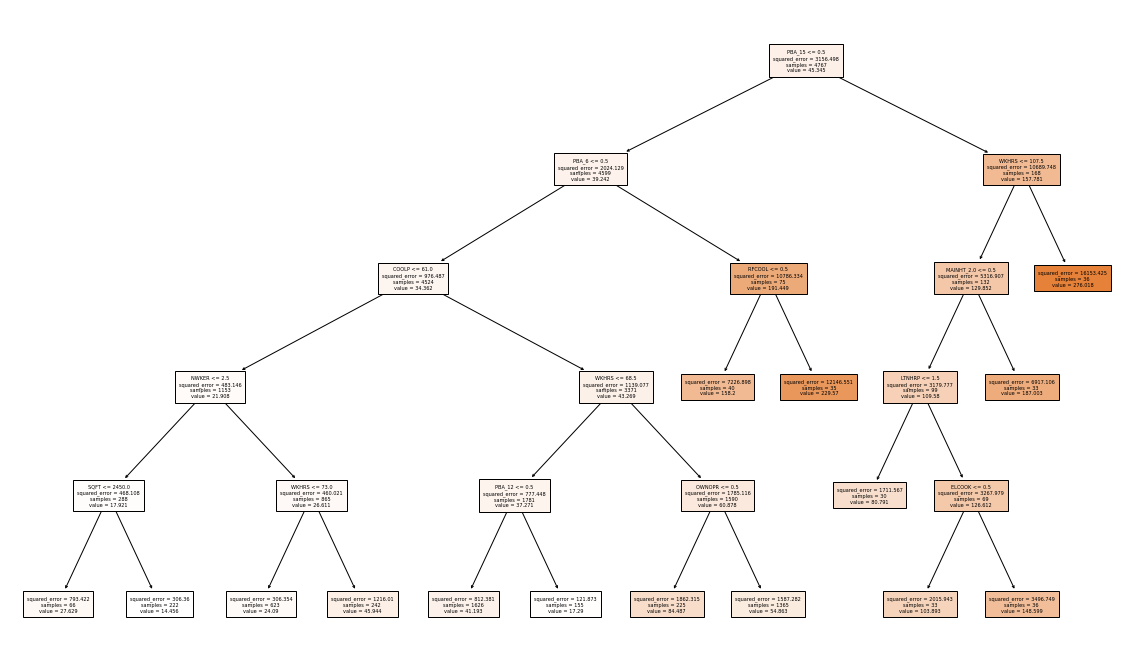

In [16]:
#plot decision tree
w = 20
h = 12

fig = plt.figure(figsize=(w,h))

tree_structure = tree.plot_tree(optimal_model,feature_names=x_test.columns,filled=True, fontsize=5)
plt.savefig('decision tree.jpg')

In [17]:
# calculate the relative importance of features
feature_importance = len(list(optimal_model.feature_importances_))
feature_importance_dict = dict(zip(list(x_train.columns),list(optimal_model.feature_importances_)))
material_features = {k:v for k,v in feature_importance_dict.items() if v > 0 }
sorted_dict = dict(sorted(material_features.items(),key=lambda x: x[1]))

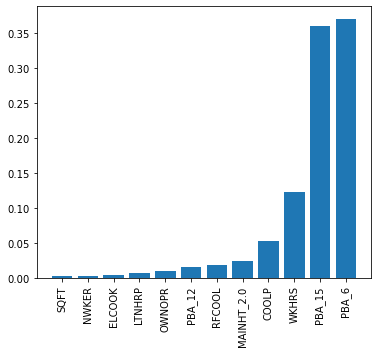

In [22]:
#plot feature importance 
w = 6
h = 6
fig = plt.figure(figsize=(w,h))
ax= fig.add_subplot(111)
plt.subplots_adjust(bottom=0.25)
x=sorted_dict.keys()
y=sorted_dict.values()
ax.bar(x,y)
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x,rotation=90)
plt.show()